In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pickle

In [37]:
# Load dataset
df1 = pd.read_csv('adm_data.csv')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Serial No.         400 non-null    int64  
 1   GRE Score          400 non-null    int64  
 2   TOEFL Score        400 non-null    int64  
 3   University Rating  400 non-null    int64  
 4   SOP                400 non-null    float64
 5   LOR                400 non-null    float64
 6   CGPA               400 non-null    float64
 7   Research           400 non-null    int64  
 8   Chance of Admit    400 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 28.3 KB


In [38]:
df2 = pd.read_csv('graduate_admission1.csv')
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GRE Score          1000 non-null   int64  
 1   TOEFL Score        1000 non-null   int64  
 2   University Rating  1000 non-null   int64  
 3   SOP                1000 non-null   float64
 4   LOR                1000 non-null   float64
 5   GPA                1000 non-null   float64
 6   Research           1000 non-null   int64  
 7   Chance of Admit    1000 non-null   float64
dtypes: float64(4), int64(4)
memory usage: 62.6 KB


In [61]:
# Membersihkan spasi di nama kolom & hapus Serial No.
df1.columns = df1.columns.str.strip()
df2.columns = df2.columns.str.strip()

if 'Serial No.' in df1.columns:
    df1 = df1.drop('Serial No.', axis=1)

In [62]:
# Standardisasi Skala GPA (df1 Scale 10 ke df2 Scale 4) agar dataset setara
df1 = df1.rename(columns={'CGPA': 'GPA'})
df1['GPA'] = (df1['GPA'] / 10) * 4

df1.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,GPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,1.5440,1,0.92
1,324,107,4,4.0,4.5,1.4192,1,0.76
2,316,104,3,3.0,3.5,1.2800,1,0.72
3,322,110,3,3.5,2.5,1.3872,1,0.80
4,314,103,2,2.0,3.0,1.3136,0,0.65


In [63]:
# Menggabungkan dataset dan hapus duplikat
df_final = pd.concat([df1, df2], axis=0, ignore_index=True)
df_final = df_final.drop_duplicates()

df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GRE Score          1400 non-null   int64  
 1   TOEFL Score        1400 non-null   int64  
 2   University Rating  1400 non-null   int64  
 3   SOP                1400 non-null   float64
 4   LOR                1400 non-null   float64
 5   GPA                1400 non-null   float64
 6   Research           1400 non-null   int64  
 7   Chance of Admit    1400 non-null   float64
dtypes: float64(4), int64(4)
memory usage: 87.6 KB


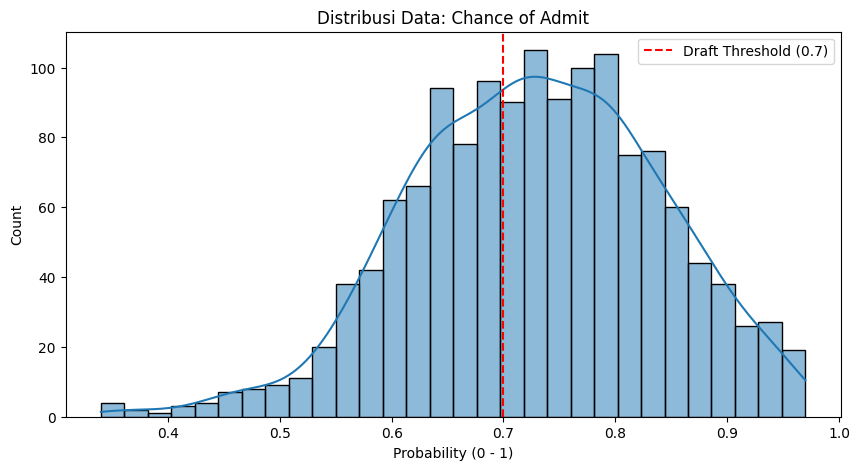

count    1400.000000
mean        0.727831
std         0.110777
min         0.340000
25%         0.650000
50%         0.729500
75%         0.804000
max         0.970000
Name: Chance of Admit, dtype: float64

In [64]:
# Plot histogram untuk membantu penentuan Threshold
plt.figure(figsize=(10, 5))
sns.histplot(df_final['Chance of Admit'], kde=True, bins=30)
plt.title('Distribusi Data: Chance of Admit')
plt.xlabel('Probability (0 - 1)')
plt.axvline(x=0.7, color='red', linestyle='--', label='Draft Threshold (0.7)')
plt.legend()
plt.show()

# Cek statistik deskriptifnya
df_final['Chance of Admit'].describe()

In [65]:
# Buat kolom target dengan threshold yang sesuai dengan mean
threshold = df_final['Chance of Admit'].mean()
df_final['Admitted_Status'] = (df_final['Chance of Admit'] > threshold).astype(int)

# Cek keseimbangan kelas (0 vs 1)
print("Proporsi Kelas Target (0 = Ditolak, 1 = Diterima):")
print(df_final['Admitted_Status'].value_counts(normalize=True))

df_final = df_final.drop('Chance of Admit', axis=1)

Proporsi Kelas Target (0 = Ditolak, 1 = Diterima):
Admitted_Status
1    0.51
0    0.49
Name: proportion, dtype: float64


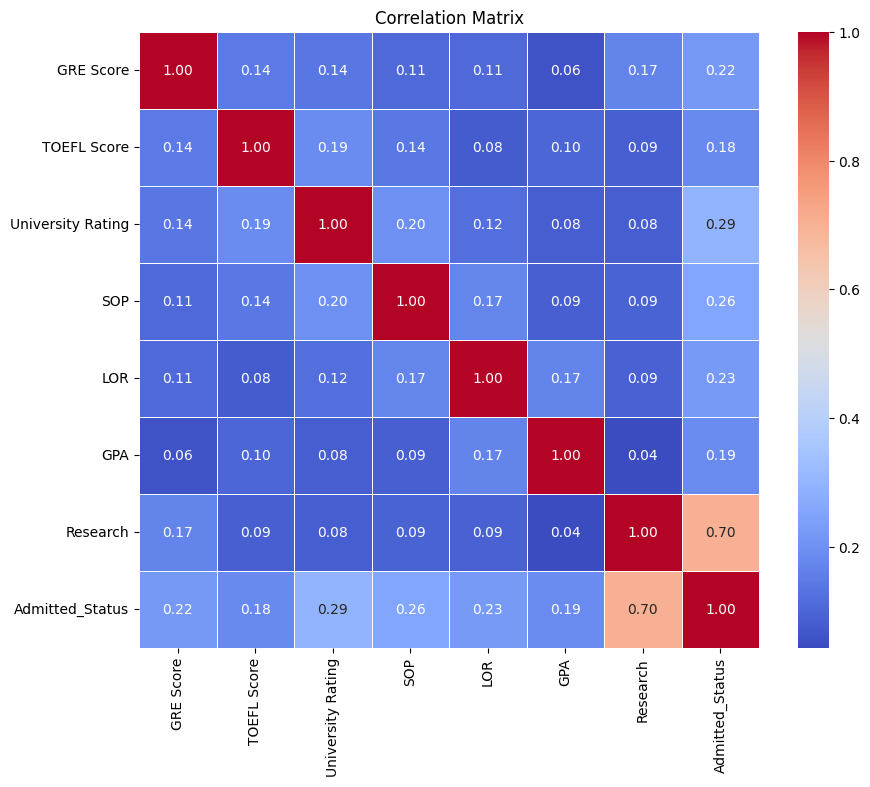

In [49]:
plt.figure(figsize=(10, 8))
# Hitung korelasi
correlation = df_final.corr()

# Tampilkan heatmap
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [50]:
df_final.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,GPA,Research,Admitted_Status
0,337,118,4,4.5,4.5,3.860,1,1
1,324,107,4,4.0,4.5,3.548,1,1
2,316,104,3,3.0,3.5,3.200,1,0
3,322,110,3,3.5,2.5,3.468,1,1
4,314,103,2,2.0,3.0,3.284,0,0


In [51]:
# Pisahkan Fitur (X) dan Target (y)
X = df_final.drop('Admitted_Status', axis=1)
y = df_final['Admitted_Status']

# Split data: 80% Training, 20% Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape Data Training:", X_train.shape)
print("Shape Data Testing :", X_test.shape)
print("\nProporsi label di Training Set:")
print(y_train.value_counts(normalize=True))

Shape Data Training: (1120, 7)
Shape Data Testing : (280, 7)

Proporsi label di Training Set:
Admitted_Status
1    0.522321
0    0.477679
Name: proportion, dtype: float64


In [53]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

# Cross-Validation
print("=== Hasil Akurasi Rata-Rata (5-Fold CV) ===")
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring='accuracy')
    print(f"{name.ljust(20)}: {scores.mean():.4f}")

=== Hasil Akurasi Rata-Rata (5-Fold CV) ===
Logistic Regression : 0.8902
Random Forest       : 0.8821
XGBoost             : 0.8679


Karena Logistic regression mendapat akurasi lebih tinggi, maka kami menggunakan LR sebagai model utama

In [54]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definisi Parameter Grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],      # Mengatur kekuatan regularisasi (Mencegah overfitting)
    'solver': ['liblinear', 'lbfgs']   # Algoritma optimasi matematika
}

# Setup Grid Search
grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("Sedang melakukan pencarian parameter terbaik...")
grid_search.fit(X_train_scaled, y_train)

# Hasil Tuning (Best Parameters)
print(f"\nParameter Terbaik ditemukan: {grid_search.best_params_}")
print(f"Akurasi Terbaik saat Validasi (Training): {grid_search.best_score_:.4f}")

# Evaluasi Akhir pada Data Test
# Kita gunakan model terbaik hasil tuning tadi untuk memprediksi X_test
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

print("\n=== LAPORAN EVALUASI FINAL (DATA TEST) ===")
print(classification_report(y_test, y_pred))

Sedang melakukan pencarian parameter terbaik...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Parameter Terbaik ditemukan: {'C': 10, 'solver': 'liblinear'}
Akurasi Terbaik saat Validasi (Training): 0.8911

=== LAPORAN EVALUASI FINAL (DATA TEST) ===
              precision    recall  f1-score   support

           0       0.93      0.90      0.92       151
           1       0.89      0.92      0.90       129

    accuracy                           0.91       280
   macro avg       0.91      0.91      0.91       280
weighted avg       0.91      0.91      0.91       280



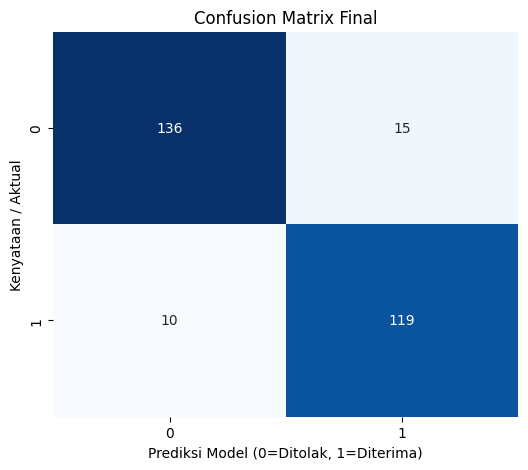

In [57]:
# Visualisasi Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix Final')
plt.xlabel('Prediksi Model (0=Ditolak, 1=Diterima)')
plt.ylabel('Kenyataan / Aktual')
plt.show()

C:\Users\N7N0L\AppData\Local\Temp\ipykernel_27184\3780648807.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')


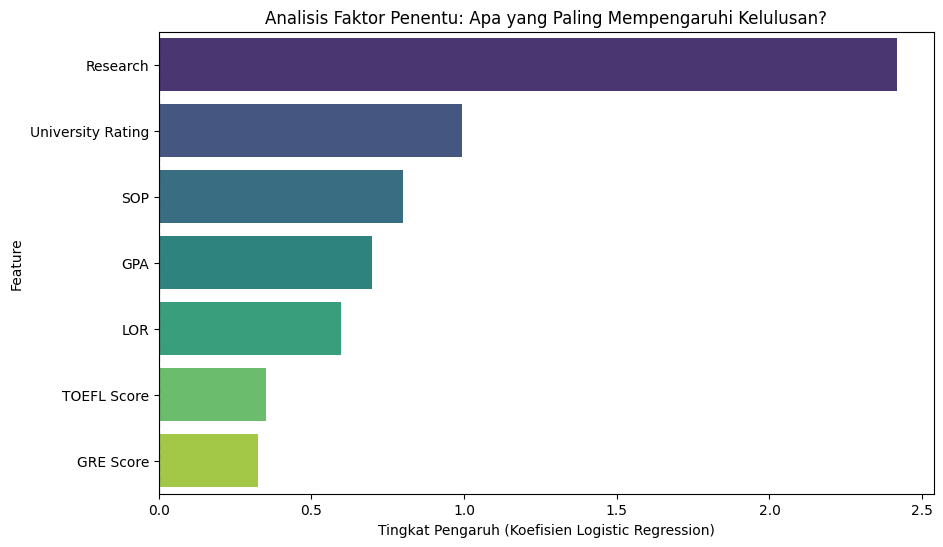

=== Peringkat Faktor Penentu ===
             Feature  Importance
6           Research    2.416810
2  University Rating    0.994092
3                SOP    0.799925
5                GPA    0.698978
4                LOR    0.597277
1        TOEFL Score    0.351915
0          GRE Score    0.324770


In [58]:
# best_model adalah Logistic Regression yang sudah dituning (C=10)
coefficients = best_model.coef_[0]
feature_names = X.columns

# Buat DataFrame agar rapi
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': coefficients
})

# Urutkan dari yang paling berpengaruh positif ke negatif
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
# Kita pakai warna gradasi: Hijau (Positif) ke Merah (Negatif)
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title('Analisis Faktor Penentu: Apa yang Paling Mempengaruhi Kelulusan?')
plt.xlabel('Tingkat Pengaruh (Koefisien Logistic Regression)')
plt.axvline(x=0, color='black', linestyle='--')
plt.show()

# Tampilkan Angkanya
print("=== Peringkat Faktor Penentu ===")
print(feature_importance)

In [59]:
# Simpan model
filename = 'dss_admission_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"\nModel berhasil disimpan sebagai '{filename}'")


Model berhasil disimpan sebagai 'dss_admission_model.pkl'


In [60]:
with open('dss_admission_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Scaler berhasil disimpan sebagai 'dss_admission_scaler.pkl'")

Scaler berhasil disimpan sebagai 'dss_admission_scaler.pkl'
